Ricardo Kaleb Flores Alfonso 	| 	A01198716
Iván Alejandro López Valenzuela 	| 	A01284875
David Alejandro Acuña Orozco	|	A00571187
Raúl Correa Ocañas			|	A01722401
Carol Jatziry Rendon Guerrero	|	A01425341

# Solution Template

Use this notebook as a guide to implement your solution. Keep in mind that some cells should remain as they are so that you code works properly, for instance, the following cell in which the required libraries are imported. However, you can add more cells in case that is necessary.

In [143]:
!pip install pybbn

In [144]:
import pandas as pd
import numpy as np
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
from pybbn.graph.dag import Bbn # for creating Bayesian Belief Networks (BBN)
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Just run the next cell to load the data.

In [145]:
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Create a new column called `Overweight` in which a person whose `BMI` is above 25 will be tagged as a one, and zero otherwise.

In [146]:
diabetes['Overweight'] = diabetes['BMI'].apply(lambda x: 1 if x > 25 else 0)
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,2,138,62,35,0,33.6,0.127,47,1,1
1,0,84,82,31,125,38.2,0.233,23,0,1
2,0,145,0,0,0,44.2,0.630,31,1,1
3,0,135,68,42,250,42.3,0.365,24,1,1
4,1,139,62,41,480,40.7,0.536,21,0,1


You are to code the next function, which discretize all the variables of the dataset, except `Outcome` and `Overweight`. Remember that you will discretize with respect to the quantiles of each variables: if a variable value is less than Q1, then said value is replaced by a **zero**; if the given value is greater or equal than Q1 but less than Q2, then the value should be replaced by a **one**; if the variable value is greater or equal than Q2 but less than Q3, then the value should be replaced by a **two**; finally, if a variable value is greater than Q3, it should be assigned the value **three**.

In [147]:
def discretize(df):

    """
    This function receives a dataframe as input and returns a dataframe in which each variable has been
    discretized.
    """

    for column in df.columns:
        if column != 'Outcome' and column != 'Overweight':
          quar25 = df[column][df[column]>0].describe().loc['25%']
          quar50 = df[column][df[column]>0].describe().loc['50%']
          quar75 = df[column][df[column]>0].describe().loc['75%']

          df[column] = df[column].apply(lambda x: 0 if x < quar25 else 1 if x >= quar25 and x < quar50 else 2 if x >= quar50 and x < quar75 else 3)
    discretized_df = df

    return discretized_df

In [148]:
discrete_df = discretize(diabetes)
discrete_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,1,2,0,2,0,2,0,3,1,1
1,0,0,3,2,1,3,0,0,0,1
2,0,3,0,0,0,3,3,2,1,1
3,0,2,1,3,3,3,1,1,1,1
4,0,2,0,3,3,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,1,0,1,1,0,1,1,2,0,1
1996,3,3,2,3,2,2,3,2,1,1
1997,3,0,2,0,0,1,2,3,0,1
1998,0,2,3,3,2,3,1,1,1,1


In the following cel you are to create two dictionaries: `graph` will store the topology of the Bayesian network, so each element is associated to a list that contains the names of the parents of said element; `values` stores the values that each variable of the network takes, which are the discrete values that were computed above.

In [149]:
graph = {'Overweight': [],
         'DiabetesPedigreeFunction': [],
         'Age': [],
         'Pregnancies': [],
         'SkinThickness' : ["Overweight"],
         'BMI': ["Overweight"],
         'Outcome': ["Age","DiabetesPedigreeFunction","Overweight","Pregnancies"],
         'BloodPressure': ["Overweight","Outcome"],
         'Insulin': ["Outcome"],
         'Glucose': ["Outcome"]}

values = {'Overweight': [0,1],
          'DiabetesPedigreeFunction': [0,1,2,3],
          'Age': [0,1,2,3],
          'Pregnancies': [0,1,2,3],
          'SkinThickness' : [0,1,2,3],
          'BMI': [0,1,2,3],
          'Outcome': [0,1],
          'BloodPressure': [0,1,2,3],
          'Insulin': [0,1,2,3],
          'Glucose': [0,1,2,3]}

The next function obtains the probabilities of a given node. This function will be used later to create a dictionary in which each element contains a node and its list of probabilities.

In [150]:
import itertools
import pandas as pd

In [151]:
def probabilities(df, node, graph, values):

    """
    This function computes the probabilities of a given node. It should receive a dataframe and the dictionaries
    graph and values. The probabilities shoud be stored in a list and returned in probabilities_list.
    """

    probabilities_list = []

    val = values[node]

    if not graph[node]:  # Si no hay nodos papas
        probabilities_list = (df[node].value_counts(normalize=True).reindex(val, fill_value=0).sort_index()).tolist()
    else:
        probabilities_list = []
        papas = graph[node]
        val_papas = [values[papa] for papa in papas]
        for parent_combination in itertools.product(*val_papas):
            for i, papa in enumerate(papas):
                df_filtrado = df[df[papa] == parent_combination[i]]
            probabilities_list.extend((df_filtrado[node].value_counts(normalize=True).reindex(val, fill_value=0).sort_index()).tolist())
    return probabilities_list

    return probabilities_list

The following function must create a dictionary in which item is a node and its corresponding list of probabilities

In [152]:
def tables(df, graph, values):

    """
    This function returns a dictionary in which each element is a node and its list of probabilities. It should
    call the above function, probabilities, which computes the probabilities of a given node.
    """

    probabilities_tables = {}

    for column in df.columns:
        probabilities_tables[column] = probabilities(df, column, graph,values)

    return probabilities_tables

In [153]:
prob_tables = tables(discrete_df, graph, values)

Create the nodes of the network in this cell. For each line, replace `"node index"` and the empty list by the proper variable name and variable values, respectively.

In [154]:
overweight_probabilities = prob_tables['Overweight']
diabetes_pedigree_function_probabilities = prob_tables['DiabetesPedigreeFunction']
age_probabilities = prob_tables['Age']
pregnancies_probabilities = prob_tables['Pregnancies']
skin_thickness_probabilities = prob_tables['SkinThickness']
bmi_probabilities = prob_tables['BMI']
outcome_probabilities = prob_tables['Outcome']
blood_pressure_probabilities = prob_tables['BloodPressure']
insulin_probabilities = prob_tables['Insulin']
glucose_probabilities = prob_tables['Glucose']

In [155]:
overweight = BbnNode(Variable("Overweight", 'Overweight',['0','1']), overweight_probabilities)
diabetes_pedigree_function = BbnNode(Variable("DiabetesPedigreeFunction", 'DiabetesPedigreeFunction', ['0','1','2','3']), diabetes_pedigree_function_probabilities)
age = BbnNode(Variable("Age", 'Age', ['0','1','2','3']), age_probabilities)
pregnancies = BbnNode(Variable("Pregnancies", 'Pregnancies', ['0','1','2','3']), pregnancies_probabilities)
skin_thickness = BbnNode(Variable("SkinThickness", 'SkinThickness', ['0','1','2','3']), skin_thickness_probabilities)
bmi = BbnNode(Variable("BMI", 'BMI', ['0','1','2','3']), bmi_probabilities)
outcome = BbnNode(Variable("Outcome", 'Outcome', ['0','1']), outcome_probabilities)
blood_pressure = BbnNode(Variable("BloodPressure", 'BloodPressure', ['0','1','2','3']), blood_pressure_probabilities)
insulin = BbnNode(Variable("Insulin", 'Insulin', ['0','1','2','3']), insulin_probabilities)
glucose = BbnNode(Variable("Glucose", 'Glucose', ['0','1','2','3']), glucose_probabilities)

Implement your graph in the following cell. Add as many nodes and edges as necessary. Replace the strings by the proper variables.

In [156]:
bbn = Bbn() \
    .add_node(overweight) \
    .add_node(diabetes_pedigree_function) \
    .add_node(age) \
    .add_node(pregnancies) \
    .add_node(skin_thickness) \
    .add_node(bmi) \
    .add_node(outcome) \
    .add_node(blood_pressure) \
    .add_node(insulin) \
    .add_node(glucose) \
    .add_edge(Edge(overweight, skin_thickness, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bmi, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes_pedigree_function, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(age, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(pregnancies, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, insulin, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, glucose, EdgeType.DIRECTED))

Do not forget to run this cell and do not modify it, inferences depend on it.

In [157]:
# Convert the BBN to a join tree. Do not modify this cell.

join_tree = InferenceController.apply(bbn)

The following cell is very useful for visualizing your Bayesian network. It is very recommended that you make the necessary changes and run it to verify that your network was implementented correctly.

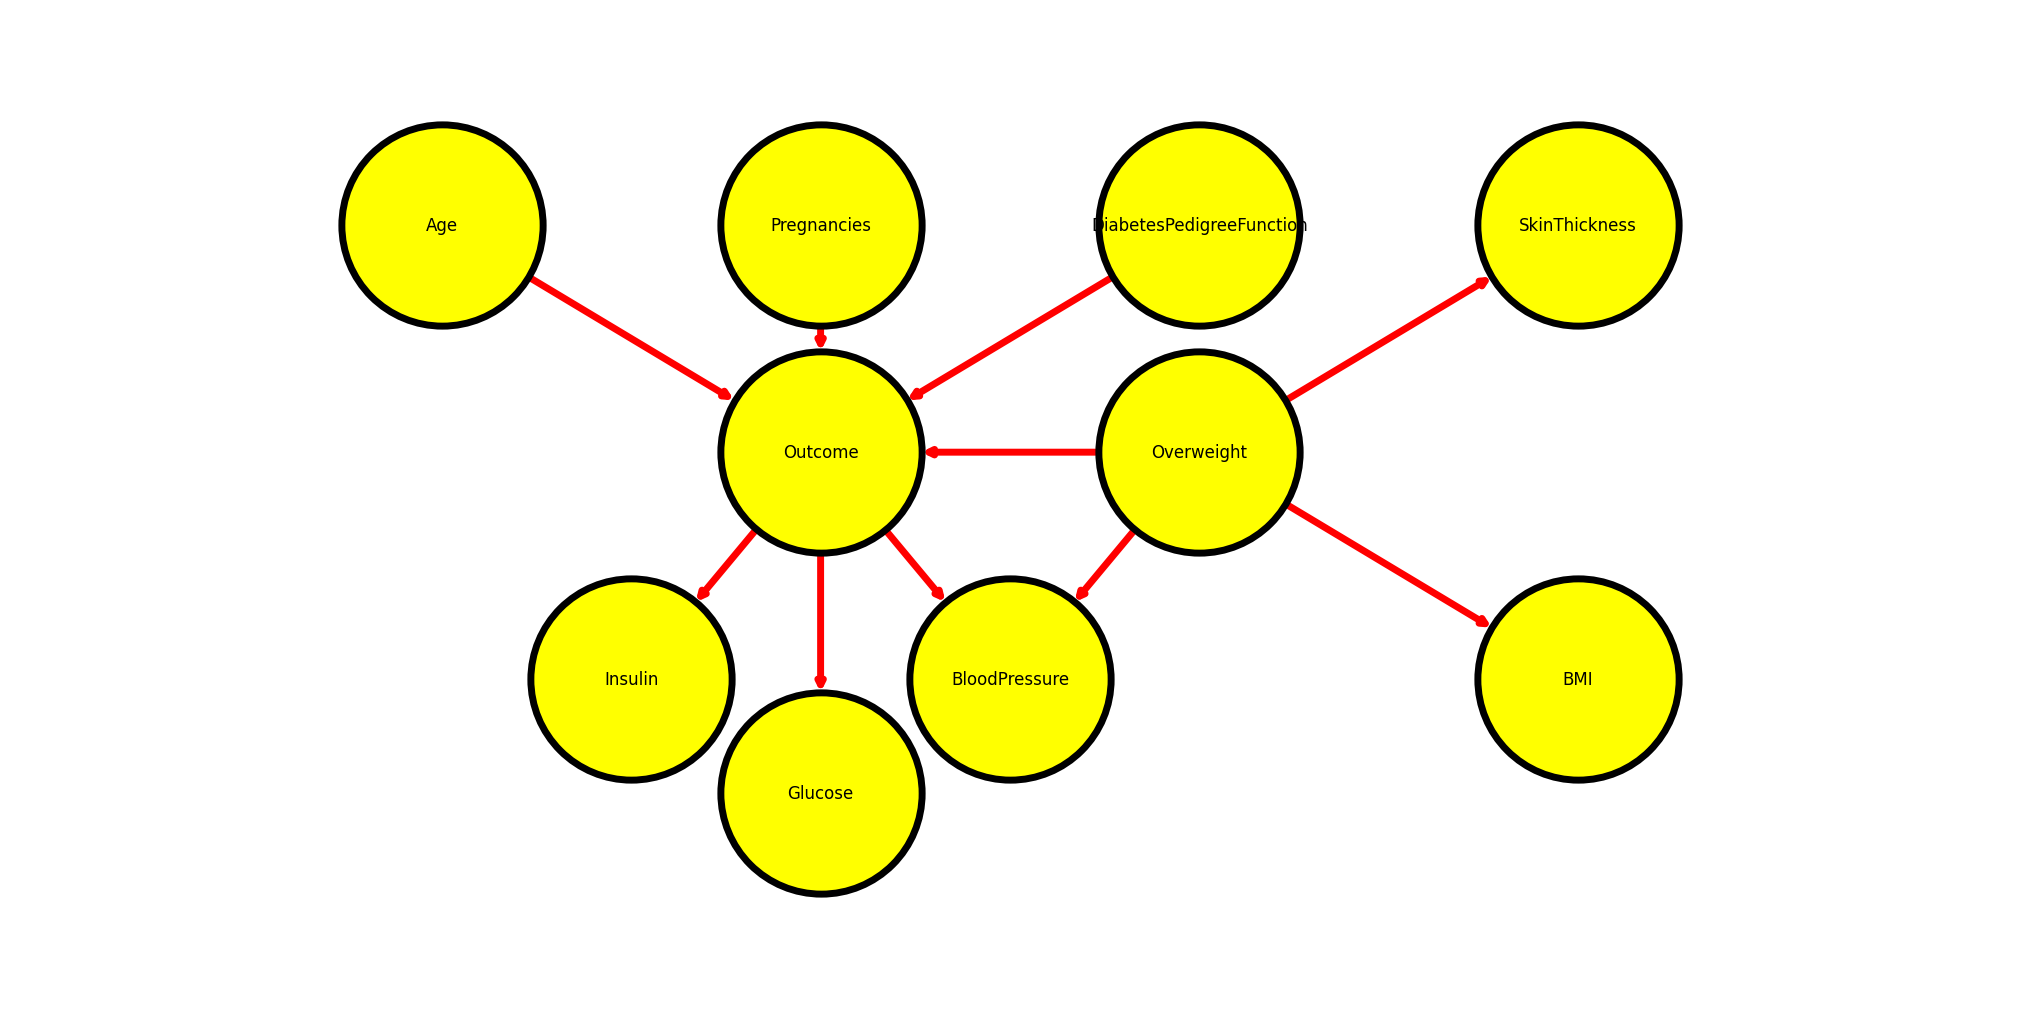

In [158]:
# Set node positions.

plt.figure(figsize=(20, 10))
pos = {"Overweight": (1, 0), "DiabetesPedigreeFunction": (1, 2), "Age": (-1, 2),"Pregnancies":(0,2),"SkinThickness":(2,2),"BMI":(2,-2),"Outcome":(0,0),"BloodPressure":(0.5,-2),"Insulin":(-0.5,-2),"Glucose":(0,-3)}

# Set options for graph looks. You might have to adjust these parameters.

options = {"font_size" : 12, "node_size" : 21000, "node_color" : "yellow",
           "edgecolors" : "black", "edge_color" : "red", "linewidths" : 5,
           "width": 5}

# Generate graph.

n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph.

ax = plt.gca()
ax.margins(0.3)
plt.axis("off")
plt.show()

The goal of `print_probs` is to print out the probability distributions of all the nodes of the network. You can modify this code to print only the distributions of certain nodes if you find that helpful.

In [159]:
# Define a function for printing marginal probabilities.

def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')

# Use the above function to print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|0.15300
Overweight=1|0.84700
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|0.25650
BMI=1|0.24700
BMI=2|0.24550
BMI=3|0.25100
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.65800
Outcome=1|0.34200
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|0.23550
Glucose=1|0.25550
Glucose=2|0.25500
Glucose=3|0.25400
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|0.60850
Insulin=1|0.12950
Insulin=2|0.12900
Insulin=3|0.13300
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.45900
SkinThickness=1|0.16650
SkinThickness=2|0.17750
SkinThickness=3|0.19700
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.25000
BloodPressure=1|0.23650
BloodPressure=2|0.25200
BloodPressure=3|0.26150
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|0.32850
Pregnancies=1|0.23950
Pregnancies=2|0.16600
Pregnancies=3|0.266

The function `evidence` helps tyou to create evidence that will be used for making inferences. Do not modify this cell, please.

In [160]:
# To add evidence of events that happened so probability distribution can be recalculated.

def evidence(ev, nod, val, like):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(val, like) \
    .build()
    join_tree.set_observation(ev)

Now you are ready to add evidence and print out the new distributions of your network.

In [161]:
# Use above function to add evidence.

evidence('ev1', 'Overweight', '1', 1)

# Print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|0.00000
Overweight=1|1.00000
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|0.12220
BMI=1|0.29162
BMI=2|0.28985
BMI=3|0.29634
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.65800
Outcome=1|0.34200
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|0.23550
Glucose=1|0.25550
Glucose=2|0.25500
Glucose=3|0.25400
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|0.60850
Insulin=1|0.12950
Insulin=2|0.12900
Insulin=3|0.13300
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.38843
SkinThickness=1|0.17591
SkinThickness=2|0.20425
SkinThickness=3|0.23140
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.25000
BloodPressure=1|0.23650
BloodPressure=2|0.25200
BloodPressure=3|0.26150
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|0.32850
Pregnancies=1|0.23950
Pregnancies=2|0.16600
Pregnancies=3|0.266

If you need to reset the Bayesian network, rerun this line of code or rerun the above cell twice.

In [162]:
join_tree = InferenceController.apply(bbn)

## Project of the week

We are going to help a to person choose a certain food based on their **glycemic index** (GI), which is a number between 0 and 100, being pure glucose a food with a glycemic index of one hundred. Based on this index, foods are divided into three categories: *low GI* ($GI<55$), *medium GI* ($55\leq GI\leq69$), and *high GI* ($GI\geq70$).

In order to do this, we will add a decision node and a utility node to the Bayesian network. For the decision node, we will have three actions: pick either a low GI food, a medium GI food, or a high GI food. As for the utility node, we have the following utility table:

<img src="utility.png" alt="Drawing" style="width: 500px;"/>

As we can see the `Diabetes` node is a parent of the utility node.

Your mission is to, given some evidence, help a person to choose their diet among the available three options. As expected, this choice will be determined by the principle of **Maximum Expected Utility**.

To accomplish your mission, let us start by defining our set of actions and the possible states of the `Outcome` node.

In [163]:
actions = ['Low GI', 'Medium GI', 'High GI']
states = [0, 1]

In [164]:
utility_dict = {(0,"Low GI"): 60, (0,"Medium GI"): 100, (0,"High GI"): 80, (1,"Low GI"): 100, (1,"Medium GI"): 50, (1,"High GI"): 0}

In [165]:
def utility_function(state, action):

    """
    This function receives a state "s" and an action "a" and returns the corresponding value of the
    utility function, which is U(s,a).
    """

    utility = utility_dict[(state,action)]


    return utility

Now write a function that, given an evidence and a set of actions, returns the action that maximizes the expected utility.

In [166]:
def maximize_utility(probabilities):

    """
    This function finds the action that maximizes the expected utility. It receives the probabilities
    of a random node, that would be the "Outcome" node in this case, and returns the optimal action.
    Notice that you will have to call the utility_function to obtain the desired action.
    """

    best_action = None
    max_utility = float('-inf')

    for action in actions:
        utility = 0
        for state in states:
            utility += probabilities[state] * utility_function(state, action)
        if utility > max_utility:
            max_utility = utility
            best_action = action


    return best_action

Experimento 1

In [167]:
evidence('ev2', 'Glucose', '3', 1)
evidence('ev3', 'Insulin', '3', 1)

# Print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|0.15300
Overweight=1|0.84700
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|0.25650
BMI=1|0.24700
BMI=2|0.24550
BMI=3|0.25100
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.21280
Outcome=1|0.78720
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|0.00000
Glucose=1|0.00000
Glucose=2|0.00000
Glucose=3|1.00000
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|0.00000
Insulin=1|0.00000
Insulin=2|0.00000
Insulin=3|1.00000
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.45900
SkinThickness=1|0.16650
SkinThickness=2|0.17750
SkinThickness=3|0.19700
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.19856
BloodPressure=1|0.23080
BloodPressure=2|0.25856
BloodPressure=3|0.31208
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|0.28330
Pregnancies=1|0.19418
Pregnancies=2|0.17140
Pregnancies=3|0.351

In [168]:
pOutcomeExp1 = [0.21280, 0.78720]

In [169]:
utility_function(0, 'Low GI')
maximize_utility(pOutcomeExp1)

'Low GI'

In [170]:
utility_function(0, 'Medium GI')
maximize_utility(pOutcomeExp1)

'Low GI'

In [171]:
utility_function(0, 'High GI')
maximize_utility(pOutcomeExp1)

'Low GI'

In [172]:
utility_function(1, 'Low GI')
maximize_utility(pOutcomeExp1)

'Low GI'

In [173]:
utility_function(1, 'Medium GI')
maximize_utility(pOutcomeExp1)

'Low GI'

In [174]:
utility_function(1, 'High GI')
maximize_utility(pOutcomeExp1)

'Low GI'

In [175]:
join_tree = InferenceController.apply(bbn)

Experimento 2

In [176]:
evidence('ev4', 'Glucose', '3', 1)
evidence('ev5', 'Insulin', '0', 1)

# Print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|0.15300
Overweight=1|0.84700
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|0.25650
BMI=1|0.24700
BMI=2|0.24550
BMI=3|0.25100
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.36998
Outcome=1|0.63002
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|0.00000
Glucose=1|0.00000
Glucose=2|0.00000
Glucose=3|1.00000
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|1.00000
Insulin=1|0.00000
Insulin=2|0.00000
Insulin=3|0.00000
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.45900
SkinThickness=1|0.16650
SkinThickness=2|0.17750
SkinThickness=3|0.19700
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.21672
BloodPressure=1|0.23281
BloodPressure=2|0.25624
BloodPressure=3|0.29422
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|0.29926
Pregnancies=1|0.21018
Pregnancies=2|0.16949
Pregnancies=3|0.321

In [177]:
pOutcomeExp2 = [0.36998, 0.63002]

In [178]:
utility_function(0, 'Low GI')
maximize_utility(pOutcomeExp2)

'Low GI'

In [179]:
utility_function(0, 'Medium GI')
maximize_utility(pOutcomeExp2)

'Low GI'

In [180]:
utility_function(0, 'High GI')
maximize_utility(pOutcomeExp2)

'Low GI'

In [181]:
utility_function(1, 'Low GI')
maximize_utility(pOutcomeExp2)

'Low GI'

In [182]:
utility_function(1, 'Medium GI')
maximize_utility(pOutcomeExp2)

'Low GI'

In [183]:
utility_function(1, 'High GI')
maximize_utility(pOutcomeExp2)

'Low GI'

In [184]:
join_tree = InferenceController.apply(bbn)

Experimento 3

In [185]:
evidence('ev6', 'Age', '2', 1)
evidence('ev7', 'SkinThickness', '3', 1)
evidence('ev8', 'BloodPressure', '3', 1)

# Print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|0.00508
Overweight=1|0.99492
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|0.12665
BMI=1|0.29014
BMI=2|0.28838
BMI=3|0.29484
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.56023
Outcome=1|0.43977
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|0.20985
Glucose=1|0.24165
Glucose=2|0.25817
Glucose=3|0.29034
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|0.59803
Insulin=1|0.12329
Insulin=2|0.13742
Insulin=3|0.14126
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.00000
SkinThickness=1|0.00000
SkinThickness=2|0.00000
SkinThickness=3|1.00000
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.00000
BloodPressure=1|0.00000
BloodPressure=2|0.00000
BloodPressure=3|1.00000
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|0.31857
Pregnancies=1|0.22955
Pregnancies=2|0.16719
Pregnancies=3|0.284

In [186]:
pOutcomeExp3 = [0.56023, 0.43977]

In [187]:
utility_function(0, 'Low GI')
maximize_utility(pOutcomeExp3)

'Medium GI'

In [188]:
utility_function(0, 'Medium GI')
maximize_utility(pOutcomeExp3)

'Medium GI'

In [189]:
utility_function(0, 'High GI')
maximize_utility(pOutcomeExp3)

'Medium GI'

In [190]:
utility_function(1, 'Low GI')
maximize_utility(pOutcomeExp3)

'Medium GI'

In [191]:
utility_function(1, 'Medium GI')
maximize_utility(pOutcomeExp3)

'Medium GI'

In [192]:
utility_function(1, 'High GI')
maximize_utility(pOutcomeExp3)

'Medium GI'

In [193]:
join_tree = InferenceController.apply(bbn)

Experimento 4

In [194]:
evidence('ev9', 'Age', '2', 1)
evidence('ev10', 'SkinThickness', '3', 1)
evidence('ev11', 'BloodPressure', '3', 1)
evidence('ev12', 'Insulin', '3', 1)

# Print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|0.00508
Overweight=1|0.99492
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|0.12665
BMI=1|0.29014
BMI=2|0.28838
BMI=3|0.29484
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.41287
Outcome=1|0.58713
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|0.17119
Glucose=1|0.22077
Glucose=2|0.26294
Glucose=3|0.34510
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|0.00000
Insulin=1|0.00000
Insulin=2|0.00000
Insulin=3|1.00000
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.00000
SkinThickness=1|0.00000
SkinThickness=2|0.00000
SkinThickness=3|1.00000
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.00000
BloodPressure=1|0.00000
BloodPressure=2|0.00000
BloodPressure=3|1.00000
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|0.30361
Pregnancies=1|0.21454
Pregnancies=2|0.16897
Pregnancies=3|0.312

In [195]:
pOutcomeExp4 = [0.41287, 0.58713]

In [196]:
utility_function(0, 'Low GI')
maximize_utility(pOutcomeExp4)

'Low GI'

In [197]:
utility_function(0, 'Medium GI')
maximize_utility(pOutcomeExp4)

'Low GI'

In [198]:
utility_function(0, 'High GI')
maximize_utility(pOutcomeExp4)

'Low GI'

In [199]:
utility_function(1, 'Low GI')
maximize_utility(pOutcomeExp4)

'Low GI'

In [200]:
utility_function(1, 'Medium GI')
maximize_utility(pOutcomeExp4)

'Low GI'

In [201]:
utility_function(1, 'High GI')
maximize_utility(pOutcomeExp4)

'Low GI'

In [202]:
join_tree = InferenceController.apply(bbn)

Experimento 5

In [203]:
evidence('ev13', 'Overweight', '1', 1)

# Print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|0.00000
Overweight=1|1.00000
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|0.12220
BMI=1|0.29162
BMI=2|0.28985
BMI=3|0.29634
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.65800
Outcome=1|0.34200
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|0.23550
Glucose=1|0.25550
Glucose=2|0.25500
Glucose=3|0.25400
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|0.60850
Insulin=1|0.12950
Insulin=2|0.12900
Insulin=3|0.13300
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.38843
SkinThickness=1|0.17591
SkinThickness=2|0.20425
SkinThickness=3|0.23140
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.25000
BloodPressure=1|0.23650
BloodPressure=2|0.25200
BloodPressure=3|0.26150
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|0.32850
Pregnancies=1|0.23950
Pregnancies=2|0.16600
Pregnancies=3|0.266

In [204]:
pOutcomeExp5 = [0.658, 0.342]

In [205]:
utility_function(0, 'Low GI')
maximize_utility(pOutcomeExp5)

'Medium GI'

In [206]:
utility_function(0, 'Medium GI')
maximize_utility(pOutcomeExp5)

'Medium GI'

In [207]:
utility_function(0, 'High GI')
maximize_utility(pOutcomeExp5)

'Medium GI'

In [208]:
utility_function(1, 'Low GI')
maximize_utility(pOutcomeExp5)

'Medium GI'

In [209]:
utility_function(1, 'Medium GI')
maximize_utility(pOutcomeExp5)

'Medium GI'

In [210]:
utility_function(1, 'High GI')
maximize_utility(pOutcomeExp5)

'Medium GI'

In [211]:
join_tree = InferenceController.apply(bbn)

Experimento 6

In [212]:
evidence('ev14', 'Overweight', '1', 1)
evidence('ev15', 'Glucose', '1', 1)
evidence('ev16', 'Insulin', '0', 1)


# Print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|0.00000
Overweight=1|1.00000
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|0.12220
BMI=1|0.29162
BMI=2|0.28985
BMI=3|0.29634
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.81207
Outcome=1|0.18793
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|0.00000
Glucose=1|1.00000
Glucose=2|0.00000
Glucose=3|0.00000
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|1.00000
Insulin=1|0.00000
Insulin=2|0.00000
Insulin=3|0.00000
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.38843
SkinThickness=1|0.17591
SkinThickness=2|0.20425
SkinThickness=3|0.23140
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.26780
BloodPressure=1|0.23847
BloodPressure=2|0.24973
BloodPressure=3|0.24400
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|0.34414
Pregnancies=1|0.25518
Pregnancies=2|0.16413
Pregnancies=3|0.236

In [213]:
pOutcomeExp6 = [0.81207, 0.18793]

In [214]:
utility_function(0, 'Low GI')
maximize_utility(pOutcomeExp6)

'Medium GI'

In [215]:
utility_function(0, 'Medium GI')
maximize_utility(pOutcomeExp6)

'Medium GI'

In [216]:
utility_function(0, 'High GI')
maximize_utility(pOutcomeExp6)

'Medium GI'

In [217]:
utility_function(1, 'Low GI')
maximize_utility(pOutcomeExp6)

'Medium GI'

In [218]:
utility_function(1, 'Medium GI')
maximize_utility(pOutcomeExp6)

'Medium GI'

In [219]:
utility_function(1, 'High GI')
maximize_utility(pOutcomeExp6)

'Medium GI'

In [230]:
join_tree = InferenceController.apply(bbn)

Experimento 7

In [231]:
evidence('ev17', 'Overweight', '0', 1)
evidence('ev18', 'Glucose', '0', 1)
evidence('ev19', 'Insulin', '0', 1)
evidence('ev20', 'Pregnancies', '0', 1)

# Print marginal probabilities.

print_probs()

Node: Overweight|Overweight|0,1
Values:
Overweight=0|1.00000
Overweight=1|0.00000
----------------
Node: BMI|BMI|0,1,2,3
Values:
BMI=0|1.00000
BMI=1|0.00000
BMI=2|0.00000
BMI=3|0.00000
----------------
Node: Outcome|Outcome|0,1
Values:
Outcome=0|0.94307
Outcome=1|0.05693
----------------
Node: Glucose|Glucose|0,1,2,3
Values:
Glucose=0|1.00000
Glucose=1|0.00000
Glucose=2|0.00000
Glucose=3|0.00000
----------------
Node: Insulin|Insulin|0,1,2,3
Values:
Insulin=0|1.00000
Insulin=1|0.00000
Insulin=2|0.00000
Insulin=3|0.00000
----------------
Node: SkinThickness|SkinThickness|0,1,2,3
Values:
SkinThickness=0|0.84967
SkinThickness=1|0.11438
SkinThickness=2|0.02941
SkinThickness=3|0.00654
----------------
Node: BloodPressure|BloodPressure|0,1,2,3
Values:
BloodPressure=0|0.28294
BloodPressure=1|0.24015
BloodPressure=2|0.24780
BloodPressure=3|0.22911
----------------
Node: Pregnancies|Pregnancies|0,1,2,3
Values:
Pregnancies=0|1.00000
Pregnancies=1|0.00000
Pregnancies=2|0.00000
Pregnancies=3|0.000

In [232]:
pOutcomeExp7 = [0.94307, 0.05693]

In [233]:
utility_function(0, 'Low GI')
maximize_utility(pOutcomeExp7)

'Medium GI'

In [234]:
utility_function(0, 'Medium GI')
maximize_utility(pOutcomeExp7)

'Medium GI'

In [235]:
utility_function(0, 'High GI')
maximize_utility(pOutcomeExp7)

'Medium GI'

In [236]:
utility_function(1, 'Low GI')
maximize_utility(pOutcomeExp7)

'Medium GI'

In [237]:
utility_function(1, 'Medium GI')
maximize_utility(pOutcomeExp7)

'Medium GI'

In [238]:
utility_function(1, 'High GI')
maximize_utility(pOutcomeExp7)

'Medium GI'

In [239]:
join_tree = InferenceController.apply(bbn)